# ASVspoof5 Train-Only Probe (Tuned) ? B -> C Bonafide vs Spoof

This version reduces overfitting risk by:
- splitting `B` speakers into `B_train` / `B_val` (speaker-disjoint)
- tuning logistic regularization (`C`) and `class_weight`
- tuning the decision threshold on `B_val`
- retraining on full `B` with chosen hyperparameters
- evaluating once on `C`


In [1]:
import json
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torchaudio
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report


In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PROJECT_ROOT = Path("/home/SpeakerRec/BioVoice")
MANIFEST_PATH = PROJECT_ROOT / "redimnet" / "tcav" / "deepfakes" / "asvspoof5" / "asvspoof5_train_only_selected_utterances_plan.csv"
SUBSET_AUDIO_ROOT = PROJECT_ROOT / "data" / "datasets" / "asvspoof5_train_only_subset_audio"
EMBED_CACHE_DIR = PROJECT_ROOT / "data" / "embeddings" / "asvspoof5_train_only_abc"
EMBED_CACHE_DIR.mkdir(parents=True, exist_ok=True)

# Tuning config (speaker-disjoint split inside group B)
VAL_SPEAKER_COUNT = 3      # from 15 B speakers -> 12 train, 3 val
TUNE_SEED = 42
C_GRID = [0.01, 0.1, 1.0, 10.0]
CLASS_WEIGHT_OPTIONS = [None, 'balanced']
THRESH_GRID = np.linspace(0.05, 0.95, 181)
FORCE_RECOMPUTE_EMBEDDINGS = False

print("DEVICE:", DEVICE)
print("MANIFEST_PATH:", MANIFEST_PATH)
print("SUBSET_AUDIO_ROOT:", SUBSET_AUDIO_ROOT)

OUT_DIR = PROJECT_ROOT / 'data' / 'models' / 'asvspoof5_train_only_probe_BC_global_tuned'
OUT_DIR.mkdir(parents=True, exist_ok=True)
CACHE_NPZ = EMBED_CACHE_DIR / 'embeddings_BC_global.npz'


DEVICE: cuda
MANIFEST_PATH: /home/SpeakerRec/BioVoice/redimnet/tcav/deepfakes/asvspoof5/asvspoof5_train_only_selected_utterances_plan.csv
SUBSET_AUDIO_ROOT: /home/SpeakerRec/BioVoice/data/datasets/asvspoof5_train_only_subset_audio


In [3]:
LABEL_MAP = {"bonafide": 0, "spoof": 1}


def build_audio_path(row, subset_root: Path) -> Path:
    return subset_root / str(row["group"]) / str(row["label"]) / f"{row['utt_id']}.flac"


def load_manifest(manifest_path: Path, subset_root: Path) -> pd.DataFrame:
    df = pd.read_csv(manifest_path).copy()
    req = {"group","speaker_id","utt_id","label","system_id"}
    missing = req - set(df.columns)
    if missing:
        raise ValueError(f"Manifest missing columns: {sorted(missing)}")
    df["label_str"] = df["label"].astype(str)
    df["label_id"] = df["label_str"].map(LABEL_MAP).astype(int)
    df["audio_path"] = df.apply(lambda r: str(build_audio_path(r, subset_root)), axis=1)
    df["audio_exists"] = df["audio_path"].map(lambda p: Path(p).exists())
    return df


def embed_with_redim(model, wav_path: str, device: str) -> np.ndarray:
    wav, sr = torchaudio.load(wav_path)
    if sr != 16000:
        wav = torchaudio.functional.resample(wav, sr, 16000)
    if wav.shape[0] > 1:
        wav = wav[:1, :]
    wav = wav.to(device)
    with torch.no_grad():
        emb = model(wav)
    return emb.squeeze(0).detach().cpu().numpy().astype(np.float32)


def extract_embeddings_for_df(df_paths: pd.DataFrame, model, device: str, cache_npz: Path, force_recompute: bool=False):
    if cache_npz.exists() and not force_recompute:
        payload = np.load(cache_npz, allow_pickle=True)
        X = payload['X']
        utt_ids = payload['utt_ids'].astype(str)
        lut = pd.DataFrame({'utt_id': utt_ids, '_idx': np.arange(len(utt_ids))})
        m = df_paths[['utt_id']].merge(lut, on='utt_id', how='left', validate='one_to_one')
        if m['_idx'].isna().any():
            miss = m.loc[m['_idx'].isna(), 'utt_id'].tolist()[:10]
            raise RuntimeError(f"Embedding cache missing utt_ids, examples: {miss}")
        return X[m['_idx'].astype(int).to_numpy()]

    vecs, ids = [], []
    for rec in tqdm(df_paths.to_dict('records'), desc=f"Embedding {len(df_paths)}"):
        p = Path(rec['audio_path'])
        if not p.exists():
            raise FileNotFoundError(f"Missing audio: {p}")
        vecs.append(embed_with_redim(model, str(p), device))
        ids.append(str(rec['utt_id']))
    X = np.stack(vecs).astype(np.float32)
    np.savez_compressed(cache_npz, X=X, utt_ids=np.array(ids, dtype=object))
    return X


def split_B_speakers(df: pd.DataFrame, n_val_speakers=3, seed=42):
    b_speakers = sorted(df.loc[df['group'].eq('B'), 'speaker_id'].astype(str).unique().tolist())
    if len(b_speakers) <= n_val_speakers:
        raise ValueError(f"Not enough B speakers ({len(b_speakers)}) for val={n_val_speakers}")
    rng = np.random.default_rng(seed)
    shuffled = b_speakers.copy()
    rng.shuffle(shuffled)
    val = sorted(shuffled[:n_val_speakers])
    train = sorted(shuffled[n_val_speakers:])
    return train, val


def metrics_at_threshold(y_true, p1, thr):
    y_hat = (p1 >= thr).astype(int)
    cm = confusion_matrix(y_true, y_hat).tolist()
    out = {
        'threshold': float(thr),
        'accuracy': float(accuracy_score(y_true, y_hat)),
        'auc': float(roc_auc_score(y_true, p1)) if len(np.unique(y_true)) == 2 else None,
        'confusion_matrix': cm,
        'classification_report': classification_report(y_true, y_hat, output_dict=True, zero_division=0),
    }
    # balanced accuracy (manual to avoid extra import)
    tn, fp = cm[0]
    fn, tp = cm[1]
    tnr = tn / (tn + fp) if (tn + fp) else 0.0
    tpr = tp / (tp + fn) if (tp + fn) else 0.0
    out['balanced_accuracy'] = float((tnr + tpr) / 2.0)
    out['bonafide_recall'] = float(tnr)
    out['spoof_recall'] = float(tpr)
    return out, y_hat


def tune_logreg_with_speaker_val(X, y, df_meta, c_grid, class_weight_options, thresh_grid, val_speaker_count=3, seed=42):
    b_train_speakers, b_val_speakers = split_B_speakers(df_meta, n_val_speakers=val_speaker_count, seed=seed)
    is_b_train = df_meta['group'].eq('B') & df_meta['speaker_id'].astype(str).isin(b_train_speakers)
    is_b_val = df_meta['group'].eq('B') & df_meta['speaker_id'].astype(str).isin(b_val_speakers)
    is_c_test = df_meta['group'].eq('C')

    X_btr, y_btr = X[is_b_train.to_numpy()], y[is_b_train.to_numpy()]
    X_bval, y_bval = X[is_b_val.to_numpy()], y[is_b_val.to_numpy()]
    X_B, y_B = X[df_meta['group'].eq('B').to_numpy()], y[df_meta['group'].eq('B').to_numpy()]
    X_C, y_C = X[is_c_test.to_numpy()], y[is_c_test.to_numpy()]

    best = None
    tuning_rows = []
    for cw in class_weight_options:
        for cval in c_grid:
            scaler = StandardScaler()
            X_btr_s = scaler.fit_transform(X_btr)
            X_bval_s = scaler.transform(X_bval)
            clf = LogisticRegression(max_iter=2000, C=float(cval), class_weight=cw, random_state=42)
            clf.fit(X_btr_s, y_btr)
            p_bval = clf.predict_proba(X_bval_s)[:, 1]
            for thr in thresh_grid:
                m_val, _ = metrics_at_threshold(y_bval, p_bval, float(thr))
                row = {
                    'C': float(cval),
                    'class_weight': str(cw),
                    'threshold': float(thr),
                    'val_balanced_accuracy': m_val['balanced_accuracy'],
                    'val_accuracy': m_val['accuracy'],
                    'val_auc': m_val['auc'],
                    'val_bonafide_recall': m_val['bonafide_recall'],
                    'val_spoof_recall': m_val['spoof_recall'],
                }
                tuning_rows.append(row)
                key = (m_val['balanced_accuracy'], m_val['accuracy'], m_val['auc'] if m_val['auc'] is not None else -1.0)
                if best is None or key > best['_key']:
                    best = {'_key': key, **row}

    # retrain final model on full B using selected hyperparameters
    final_scaler = StandardScaler()
    X_B_s = final_scaler.fit_transform(X_B)
    X_C_s = final_scaler.transform(X_C)
    final_clf = LogisticRegression(
        max_iter=2000,
        C=float(best['C']),
        class_weight=(None if best['class_weight'] == 'None' else 'balanced'),
        random_state=42,
    )
    final_clf.fit(X_B_s, y_B)
    p_B = final_clf.predict_proba(X_B_s)[:, 1]
    p_C = final_clf.predict_proba(X_C_s)[:, 1]

    chosen_thr = float(best['threshold'])
    m_B, yhat_B = metrics_at_threshold(y_B, p_B, chosen_thr)
    m_C, yhat_C = metrics_at_threshold(y_C, p_C, chosen_thr)

    # default threshold reference (0.5) on test C for comparison
    m_C_default, yhat_C_default = metrics_at_threshold(y_C, p_C, 0.5)

    result = {
        'b_train_speakers': b_train_speakers,
        'b_val_speakers': b_val_speakers,
        'best_params': {k: best[k] for k in ['C','class_weight','threshold','val_balanced_accuracy','val_accuracy','val_auc','val_bonafide_recall','val_spoof_recall']},
        'metrics_B_tuned_threshold': m_B,
        'metrics_C_tuned_threshold': m_C,
        'metrics_C_default_threshold_0_5': m_C_default,
    }

    masks = {
        'is_B': df_meta['group'].eq('B').to_numpy(),
        'is_C': df_meta['group'].eq('C').to_numpy(),
    }
    tuning_df = pd.DataFrame(tuning_rows).sort_values(['val_balanced_accuracy','val_accuracy','val_auc'], ascending=False)
    return final_scaler, final_clf, chosen_thr, p_B, p_C, yhat_B, yhat_C, yhat_C_default, result, tuning_df, masks


def plot_confmat(cm, title):
    cm = np.array(cm)
    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, cmap='Blues')
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(['bonafide','spoof'], rotation=30, ha='right')
    ax.set_yticklabels(['bonafide','spoof'])
    ax.set_xlabel('Predicted'); ax.set_ylabel('True'); ax.set_title(title)
    for (i,j), v in np.ndenumerate(cm):
        ax.text(j, i, str(int(v)), ha='center', va='center')
    plt.colorbar(im, ax=ax, fraction=0.046)
    plt.tight_layout()
    return fig


In [4]:
redim_model = (
    torch.hub.load(
        "IDRnD/ReDimNet",
        "ReDimNet",
        model_name="b5",
        train_type="ptn",
        dataset="vox2",
    )
    .to(DEVICE)
    .eval()
)
print("Loaded ReDimNet on", DEVICE)


Using cache found in /home/SpeakerRec/.cache/torch/hub/IDRnD_ReDimNet_master


Loaded ReDimNet on cuda


In [5]:
manifest_df = load_manifest(MANIFEST_PATH, SUBSET_AUDIO_ROOT)
print('Manifest rows:', len(manifest_df))
print('Missing audio paths:', int((~manifest_df['audio_exists']).sum()))
bc_df = manifest_df[manifest_df['group'].isin(['B','C'])].copy().reset_index(drop=True)
print('B/C rows:', len(bc_df))
print(bc_df.groupby(['group','label_str']).size().unstack(fill_value=0))

X_bc = extract_embeddings_for_df(bc_df[['utt_id','audio_path']], redim_model, DEVICE, CACHE_NPZ, force_recompute=FORCE_RECOMPUTE_EMBEDDINGS)
y_bc = bc_df['label_id'].to_numpy().astype(int)

scaler, clf, thr, p_B, p_C, yhat_B, yhat_C, yhat_C_default, results, tuning_df, masks = tune_logreg_with_speaker_val(
    X_bc, y_bc, bc_df, C_GRID, CLASS_WEIGHT_OPTIONS, THRESH_GRID, val_speaker_count=VAL_SPEAKER_COUNT, seed=TUNE_SEED
)

print('B_train speakers:', results['b_train_speakers'])
print('B_val speakers:', results['b_val_speakers'])
print(json.dumps(results['best_params'], indent=2))
print(json.dumps({
    'metrics_B_tuned_threshold': {k:v for k,v in results['metrics_B_tuned_threshold'].items() if k != 'classification_report'},
    'metrics_C_tuned_threshold': {k:v for k,v in results['metrics_C_tuned_threshold'].items() if k != 'classification_report'},
    'metrics_C_default_threshold_0_5': {k:v for k,v in results['metrics_C_default_threshold_0_5'].items() if k != 'classification_report'},
}, indent=2))


Manifest rows: 3200
Missing audio paths: 0
B/C rows: 1280
label_str  bonafide  spoof
group                     
B               480    480
C               160    160
B_train speakers: ['T_0012', 'T_0519', 'T_0854', 'T_0934', 'T_1613', 'T_2498', 'T_3883', 'T_4311', 'T_4493', 'T_4830', 'T_5053', 'T_5207']
B_val speakers: ['T_3688', 'T_3753', 'T_4090']
{
  "C": 0.1,
  "class_weight": "None",
  "threshold": 0.82,
  "val_balanced_accuracy": 0.9791666666666667,
  "val_accuracy": 0.9791666666666666,
  "val_auc": 0.9983723958333334,
  "val_bonafide_recall": 0.9895833333333334,
  "val_spoof_recall": 0.96875
}
{
  "metrics_B_tuned_threshold": {
    "threshold": 0.82,
    "accuracy": 0.9989583333333333,
    "auc": 1.0,
    "confusion_matrix": [
      [
        480,
        0
      ],
      [
        1,
        479
      ]
    ],
    "balanced_accuracy": 0.9989583333333334,
    "bonafide_recall": 1.0,
    "spoof_recall": 0.9979166666666667
  },
  "metrics_C_tuned_threshold": {
    "threshold": 0.8

In [6]:
# Save outputs
with open(OUT_DIR / 'scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open(OUT_DIR / 'logistic_regression.pkl', 'wb') as f:
    pickle.dump(clf, f)
(OUT_DIR / 'tuning_results_top200.csv').write_text(tuning_df.head(200).to_csv(index=False), encoding='utf-8')
(OUT_DIR / 'run_summary.json').write_text(json.dumps(results, indent=2), encoding='utf-8')

pred_B = bc_df.loc[masks['is_B'], ['group','speaker_id','utt_id','label_str','label_id','system_id']].copy().reset_index(drop=True)
pred_B['split'] = 'train_B_final'
pred_B['prob_spoof'] = p_B
pred_B['pred_label_id_tuned'] = yhat_B
pred_B['pred_label_id_thr_0_5'] = (p_B >= 0.5).astype(int)

pred_C = bc_df.loc[masks['is_C'], ['group','speaker_id','utt_id','label_str','label_id','system_id']].copy().reset_index(drop=True)
pred_C['split'] = 'test_C'
pred_C['prob_spoof'] = p_C
pred_C['pred_label_id_tuned'] = yhat_C
pred_C['pred_label_id_thr_0_5'] = yhat_C_default

pd.concat([pred_B, pred_C], ignore_index=True).to_csv(OUT_DIR / 'predictions_BC_global_tuned.csv', index=False)

coef_df = pd.DataFrame({
    'feature_index': np.arange(clf.coef_.shape[1]),
    'coefficient': clf.coef_.ravel(),
    'abs_coefficient': np.abs(clf.coef_.ravel())
}).sort_values('abs_coefficient', ascending=False)
coef_df.to_csv(OUT_DIR / 'coefficients.csv', index=False)
print('Saved outputs ->', OUT_DIR)


Saved outputs -> /home/SpeakerRec/BioVoice/data/models/asvspoof5_train_only_probe_BC_global_tuned


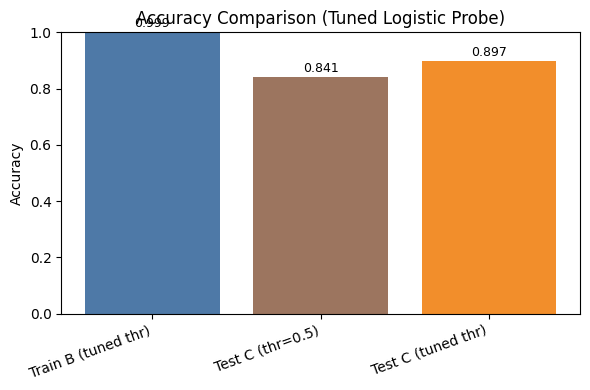

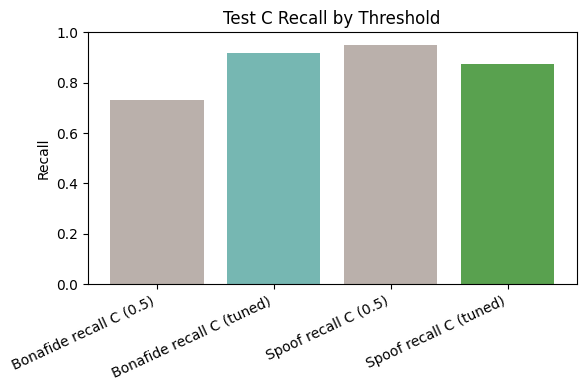

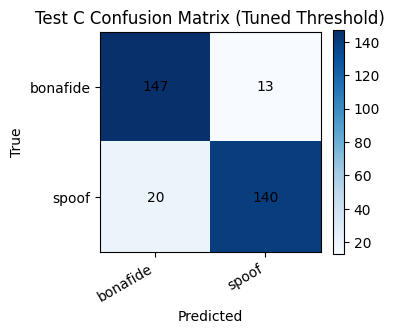

In [7]:
# Diagrams: train/test accuracy (tuned) + threshold comparison on test + confusion matrix
mB = results['metrics_B_tuned_threshold']
mC = results['metrics_C_tuned_threshold']
mC05 = results['metrics_C_default_threshold_0_5']

fig, ax = plt.subplots(figsize=(6,4))
labels = ['Train B (tuned thr)', 'Test C (thr=0.5)', 'Test C (tuned thr)']
vals = [mB['accuracy'], mC05['accuracy'], mC['accuracy']]
ax.bar(labels, vals, color=['#4e79a7','#9c755f','#f28e2b'])
ax.set_ylim(0,1)
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparison (Tuned Logistic Probe)')
for i,v in enumerate(vals):
    ax.text(i, v+0.02, f'{v:.3f}', ha='center', fontsize=9)
plt.xticks(rotation=20, ha='right')
plt.tight_layout(); plt.show()

fig, ax = plt.subplots(figsize=(6,4))
labels = ['Bonafide recall C (0.5)', 'Bonafide recall C (tuned)', 'Spoof recall C (0.5)', 'Spoof recall C (tuned)']
vals = [mC05['bonafide_recall'], mC['bonafide_recall'], mC05['spoof_recall'], mC['spoof_recall']]
ax.bar(labels, vals, color=['#bab0ab','#76b7b2','#bab0ab','#59a14f'])
ax.set_ylim(0,1)
ax.set_ylabel('Recall')
ax.set_title('Test C Recall by Threshold')
plt.xticks(rotation=25, ha='right')
plt.tight_layout(); plt.show()

plot_confmat(mC['confusion_matrix'], 'Test C Confusion Matrix (Tuned Threshold)')
plt.show()
